In [1]:
import bezier
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.spatial import ConvexHull

# Translation points to Bezier representation

In [2]:
nodes = np.asfortranarray([
        [1, 1.5, 2.5, 3],
        [1, 1.5 , 0.5, 1],
    ])
curve = bezier.Curve(nodes, degree=3)

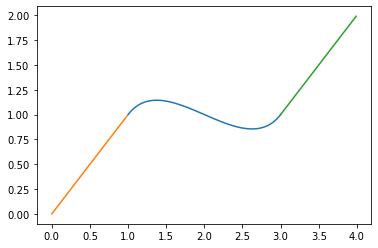

In [3]:
curve.plot(100)
plt.plot([0.01 * i for i in range(100)], [0.01 * i for i in range(100)])
plt.plot([0.01 * i + 3 for i in range(100)], [0.01 * i + 1 for i in range(100)])

In [4]:
curve.evaluate(0.5).T[0]

array([2., 1.])

In [5]:
def get_vector(segment):
    return np.array(segment[1] - segment[0])

In [6]:
get_vector(np.array([[1, 1], [2, 3]]))

array([1, 2])

In [116]:
def get_track(points, depth = 0.5):
    
    segments = []
    curves = []
    for i in range(len(points) // 2):
        segments.append([points[2*i], points[2*i+1]])
    
    segments = np.array(segments)
    for i in range(len(segments)):
        s1 = segments[i]
        s2 = segments[(i + 1) % len(segments)]
        
        v1 = depth * get_vector(s1)
        v2 = depth * get_vector(s2[::-1])
        
        nodes = np.vstack((s1[1], s1[1] + v1, s2[0] + v2, s2[0])).T
        
        curves.append(bezier.Curve(nodes, degree=3))
    
    return segments, curves

In [117]:
def draw_track(segments, curves):
    for s in segments:
        x_values = [s[0][0], s[1][0]]
        y_values = [s[0][1], s[1][1]]
        plt.plot(x_values, y_values)

    i = 0
    for c in curves:
        xs = [c.evaluate(x).T[0][0] for x in np.linspace(0, 1, 100)]
        ys = [c.evaluate(x).T[0][1] for x in np.linspace(0, 1, 100)]

        plt.plot(xs, ys)

        i += 1


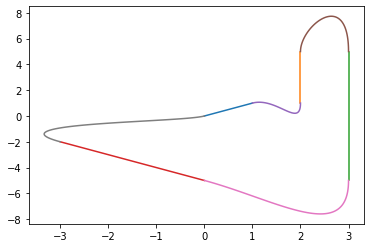

In [118]:
segments, curves = get_track([[0, 0], [1, 1], [2, 1], [2, 5], [3, 5], [3, -5], [0, -5], [-3, -2]])
draw_track(segments, curves)

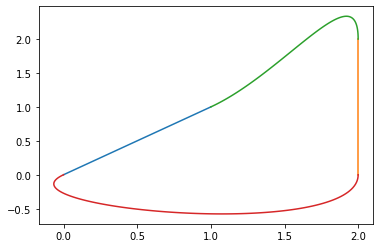

In [119]:
segments, curves = get_track([[0, 0], [1, 1], [2, 2], [2, 0]])
draw_track(segments, curves)

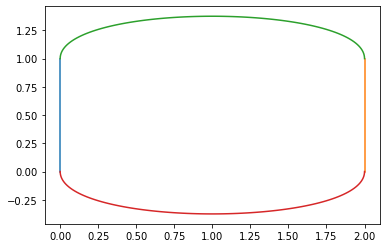

In [120]:
segments, curves = get_track([[0, 0], [0, 1], [2, 1], [2, 0]])
draw_track(segments, curves)

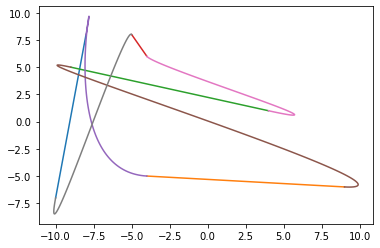

In [121]:
segments, curves = get_track([[random.randrange(-10, 10), random.randrange(-10, 10)] for _ in range(8)])
draw_track(segments, curves)

[[  4  -1]
 [ -9  -2]
 [  3   4]
 [  2  -5]
 [  5   3]
 [  0  -2]
 [  2  -4]
 [ -3   6]
 [ -5  -1]
 [ -7  -8]
 [ -3  -6]
 [ -7   0]
 [ -5  -6]
 [ -6  -3]
 [  2  -5]
 [-10   0]
 [  0   3]
 [-10 -10]
 [ -3   4]]

[[-10   0]
 [-10 -10]
 [  2  -5]
 [  4  -1]
 [  5   3]
 [  3   4]
 [ -3   6]]


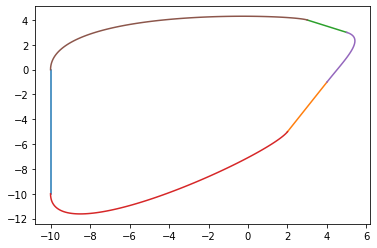

In [13]:
points = np.array([[random.randrange(-10, 10), random.randrange(-10, 10)] for _ in range(19)])

print(points)
print()
print(points[ConvexHull(points).vertices])
segments, curves = get_track(points[ConvexHull(points).vertices])
draw_track(segments, curves)

# Translation of Bezier representation to Torcs representation

In [14]:
def translate_curve(curve, K = 50):
    vecs = []
    vals = []
    anses = []
    for i in np.linspace(0,1, K + 1):
        # print(i)
        t = curve.evaluate_hodograph(i)
        tp = np.array([t[1], -t[0]])
        vecs += [tp]
        v = curve.evaluate(i)
        vals += [v]
        # print(v)

    for i in range(K):
        start_pos = vals[i]
        end_pos = vals[i+1]
        start_vec = vecs[i]
        end_vec = vecs[i+1]

        m = np.concatenate([start_vec, end_vec], axis=1)
        ans = np.linalg.inv(m) @ (end_pos - start_pos)

        d = np.linalg.det(m)

        p = start_pos + ans[0,0] * start_vec
        
        v1 = p - start_pos
        v2 = p - end_pos

        r1 = np.linalg.norm(v1)
        r2 = np.linalg.norm(v2)
        
        hmm = max(-1, min(1, v1.T.dot(v2)[0][0] / (r1 * r2)))
        #print(hmm)
        arc =  np.degrees(np.arccos(hmm))
        #print(arc)
        
        if hmm == 1:
            anses += [("Str", np.linalg.norm(start_pos - end_pos))]
        else:
            anses += [("Arc", r1, r2, arc, d>0)]
        
    # for ans in anses:
    #     print(ans)
    return anses

In [15]:
def fill_section_cur(id, left, deg, radius, end_radius):
    w = "rgt" if not left else "lft"
    return f"""
<section name="curve {id}">
    <attstr name="type" val="{w}" />
    <attnum name="arc" unit="deg" val="{deg}" />
    <attnum name="radius" unit="m" val="{radius}" />
    <attnum name="end radius" unit="m" val="{end_radius}" />
    <attnum name="z start" unit="m" val="0.0" />
    <attnum name="z end" unit="m" val="0.0" />
    <attstr name="surface" val="asphalt2-lines" />
    <!--Left part of segment-->
    <section name="Left Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Left Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Left Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of left part-->
    <!--Right part of segment-->
    <section name="Right Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Right Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Right Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of right part-->
    </section>
      """

In [16]:
def fill_section_str(id, length):
    return f"""
<section name="straight {id}">
    <attstr name="type" val="str" />
    <attnum name="lg" unit="m" val="{length}" />
    <attnum name="z start" unit="m" val="0.0" />
    <attnum name="z end" unit="m" val="0.0" />
    <attstr name="surface" val="asphalt2-lines" />
    <!--Left part of segment-->
    <section name="Left Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Left Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Left Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of left part-->
    <!--Right part of segment-->
    <section name="Right Side">
        <attnum name="start width" unit="m" val="4.0" />
        <attnum name="end width" unit="m" val="4.0" />
        <attstr name="surface" val="grass" />
    </section>
    <section name="Right Border">
        <attnum name="width" unit="m" val="0.5" />
        <attnum name="height" unit="m" val="0.05" />
        <attstr name="surface" val="curb-5cm-r" />
        <attstr name="style" val="plan" />
    </section>
    <section name="Right Barrier">
        <attnum name="width" unit="m" val="0.1" />
        <attnum name="height" unit="m" val="1.0" />
        <attstr name="surface" val="barrier" />
        <attstr name="style" val="curb" />
    </section>
    <!--End of right part-->
    </section>
      """

In [17]:
def get_len(s):
    return np.sqrt((s[1][0] - s[0][0]) ** 2 + (s[1][1] - s[0][1]) ** 2)

In [55]:
def to_xml(segments, curves):
    res  = ""
    id = 0
    for i in range(len(segments)):
        res += fill_section_str(id, get_len(segments[i]) * 100)
        id += 1
        anses = translate_curve(curves[i], 100)

        for j in range(len(anses)):
            ans = anses[j]
            if ans[0] == "Arc":
                r1, r2, arc, left = ans[1:]
                res += fill_section_cur(id, left, arc, 100*r1, 100*r2)
                id += 1
            else:
                length, = ans[1:]
                res += fill_section_str(id, length * 100)
                id += 1

    return res

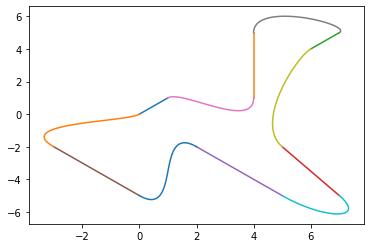

In [471]:
segments, curves = get_track(np.array([[0, 0], [1, 1], [4, 1], [4, 5], [7, 5], [6, 4], [5, -2], [7, -5], [5, -5], [2, -2], [0, -5], [-3, -2]]))
draw_track(segments, curves)
res = to_xml(segments, curves)

In [472]:
def save_to_file(s):
    with open('output.txt', "w") as f:
        f.write(s)

In [473]:
save_to_file(res)

# Curwature Entropy

2.1146474185471185


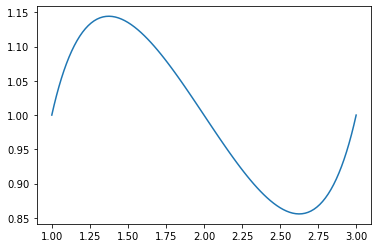

In [378]:
print(curve.length)
curve.plot(100)

1.0948198154137423


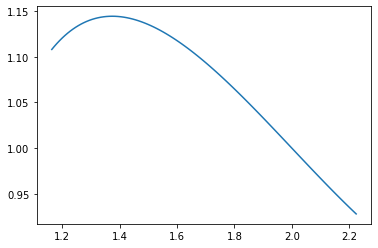

In [379]:
curve2 = curve.specialize(0.1, 0.6)
print(curve2.length)
curve2.plot(100)

In [400]:
def get_curve_stats(curve, K = 50):
    vecs = []
    vals = []
    turns = []
    lengths = []
    for i in np.linspace(0,1, K + 1):
        t = curve.evaluate_hodograph(i)
        tp = np.array([t[1], -t[0]])
        vecs += [tp]
        v = curve.evaluate(i)
        vals += [v]

    for i in range(K):
        start_pos = vals[i]
        end_pos = vals[i+1]
        start_vec = vecs[i]
        end_vec = vecs[i+1]
        
        cut = curve.specialize(i / K, (i + 1) / K)

        m = np.concatenate([start_vec, end_vec], axis=1)
        ans = np.linalg.inv(m) @ (end_pos - start_pos)

        d = np.linalg.det(m)

        p = start_pos + ans[0,0] * start_vec
        
        v1 = p - start_pos
        v2 = p - end_pos

        r1 = np.linalg.norm(v1)
        r2 = np.linalg.norm(v2)
        
        
        if max(-1, min(1, v1.T.dot(v2)[0][0] / (r1 * r2))) == 1:
            turns.append(0) 
            lengths.append(np.linalg.norm(start_pos - end_pos))
        else:
            turns.append(1 / ((r1 + r2) / 2) * np.sign(d))
            lengths.append(cut.length)
        
    return turns, lengths

In [401]:
get_curve_stats(curve)

([-1.9555541277811728,
  -2.071988072487608,
  -2.1438580335885122,
  -2.1643931845959608,
  -2.132654239880537,
  -2.0535546088632315,
  -1.9364330233848175,
  -1.7928222299377279,
  -1.6342467650878307,
  -1.4706437594664696,
  -1.3095919633558628,
  -1.156216165740873,
  -1.0135048734717484,
  -0.8827968751037079,
  -0.7642728886811366,
  -0.6573701784786897,
  -0.5610952414587506,
  -0.47424069604143276,
  -0.395524867395839,
  -0.32367443637052995,
  -0.25746773486032654,
  -0.19575215019567732,
  -0.13744520183274272,
  -0.08152572696602665,
  -0.02701932735316499,
  0.027019327353164594,
  0.08152572696602735,
  0.1374452018327417,
  0.19575215019567704,
  0.25746773486032476,
  0.3236744363705311,
  0.39552486739584186,
  0.47424069604143415,
  0.5610952414587494,
  0.6573701784786921,
  0.7642728886811379,
  0.8827968751037095,
  1.013504873471746,
  1.156216165740866,
  1.3095919633558455,
  1.4706437594665005,
  1.6342467650878374,
  1.7928222299377066,
  1.9364330233848175,

In [443]:
def get_track_stats(segments, curves):
    turns = []
    lengths = []
    for s in segments:
        turns.append(0)
        lengths.append(get_len(s))
    for c in curves:
        t, l = get_curve_stats(c)
        turns += t
        lengths += l
        
    return turns, lengths

4.216769867229083
-6.803234075133655


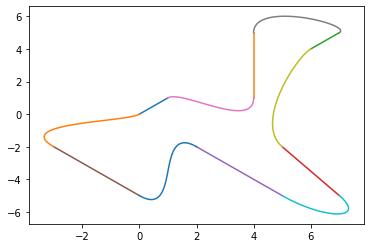

In [444]:
segments, curves = get_track(np.array([[0, 0], [1, 1], [4, 1], [4, 5], [7, 5], [6, 4], [5, -2], [7, -5], [5, -5], [2, -2], [0, -5], [-3, -2]]))
draw_track(segments, curves)
res, _ = get_track_stats(segments, curves)
print(max(res))
print(min(res))

(array([  3.,   3.,   8.,  13.,  24.,  99., 125.,  17.,  10.,   4.]),
 array([-6.80323408, -5.70123368, -4.59923329, -3.49723289, -2.3952325 ,
        -1.2932321 , -0.19123171,  0.91076868,  2.01276908,  3.11476947,
         4.21676987]),
 <a list of 10 Patch objects>)

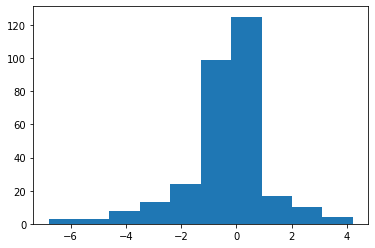

In [445]:
plt.hist(res)

11.427798724095716
-18.448360662133325


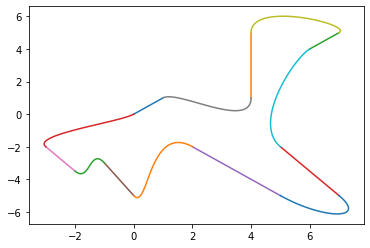

In [446]:
segments, curves = get_track(np.array([[0, 0], [1, 1], [4, 1], [4, 5], [7, 5], [6, 4], [5, -2], [7, -5], [5, -5], [2, -2], [0, -5], [-1, -3], [-2, -3.5], [-3, -2]]))
draw_track(segments, curves)

res, _ = get_track_stats(segments, curves)
print(max(res))
print(min(res))

(array([  1.,   1.,   3.,   6.,  17.,  83., 232.,   7.,   3.,   4.]),
 array([-18.44836066, -15.46074472, -12.47312878,  -9.48551285,
         -6.49789691,  -3.51028097,  -0.52266503,   2.46495091,
          5.45256685,   8.44018279,  11.42779872]),
 <a list of 10 Patch objects>)

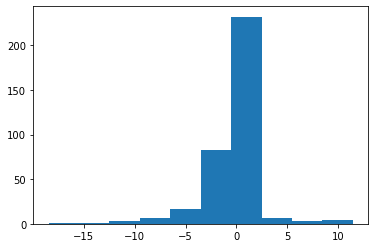

In [447]:
plt.hist(res)

0
-5.514510668356621


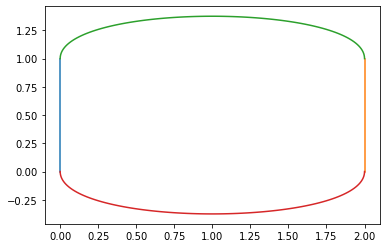

In [448]:
segments, curves = get_track([[0, 0], [0, 1], [2, 1], [2, 0]])
draw_track(segments, curves)

res, _ = get_track_stats(segments, curves)
print(max(res))
print(min(res))

In [ ]:
plt.hist(res)

In [ ]:
segments, curves = get_track(np.array([[3, 3], [4, 3], [7, 0], [7, -1], [4, -4], [3, -4], [0, -1], [0, 0]]))
draw_track(segments, curves)

res, _ = get_track_stats(segments, curves)
print(max(res))
print(min(res))

In [451]:
sum(le)

43.296792126615664

(array([  8.,   0.,   0.,   8.,   0.,   0.,   8.,   8.,  16., 156.]),
 array([-5.17049473, -4.65344525, -4.13639578, -3.61934631, -3.10229684,
        -2.58524736, -2.06819789, -1.55114842, -1.03409895, -0.51704947,
         0.        ]),
 <a list of 10 Patch objects>)

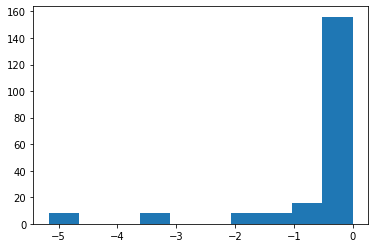

In [452]:
plt.hist(res)

In [453]:
save_to_file(to_xml(segments, curves))

In [454]:
def bin_entropy(a, bins=16, range=None, weights=None):
    """Calculate entropy from bins, the same is done in the paper
    :param a: Input data
    :param bins: int or sequence, passed to np.histogram
    :param range: range of possible values, passed to np.histogram
    :param range: weigths of input values, passed to np.histogram
    """

    p, _ = np.histogram(a, bins=bins, range=range, weights=weights)
    p1 = p[p > 0]
    if len(p1) > 0:
        p1 = p1 / p1.sum()
        return -np.sum(p1 * np.log2(p1))
    else:
        return 0.

In [466]:
def curves_entropy(points):
    segments, curves = get_track(points)
    turns, lengths = get_track_stats(segments, curves)
    length = sum(lengths)
    turns = np.array(turns)
    lengths = np.array(lengths) / length
    print(lengths.sum())
    bins = [i - 8.5 for i in range(17)]
    bins[0] = -np.inf 
    bins = [-np.inf, -7, -6, -5, -4, -3, -2, 2, 3, 4, 5, 6, 7, np.inf]
    #bins.append(np.inf)
    print(np.histogram(turns, bins=bins, range=None, weights=lengths))
    print(np.histogram(turns, bins=bins, range=None, weights=lengths)[0].sum())
    return bin_entropy(turns, bins, range=None, weights=lengths)
    

In [467]:
curves_entropy([[0, 0], [1, 1], [4, 1], [4, 5], [7, 5], [6, 4], [5, -2], [7, -5], [5, -5], [2, -2], [0, -5], [-3, -2]])

0.9999999999999998
(array([0.        , 0.00158775, 0.00167786, 0.00392619, 0.01182346,
       0.01829892, 0.94450074, 0.01208559, 0.00485374, 0.00124575,
       0.        , 0.        , 0.        ]), array([-inf,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,   2.,   3.,   4.,   5.,
         6.,   7.,  inf]))
0.9999999999999996


0.44705825313847186

In [468]:
curves_entropy([[3, 3], [4, 3], [7, 0], [7, -1], [4, -4], [3, -4], [0, -1], [0, 0]])

1.0
(array([0.        , 0.        , 0.01224309, 0.        , 0.01429538,
       0.        , 0.97346153, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), array([-inf,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,   2.,   3.,   4.,   5.,
         6.,   7.,  inf]))
1.0000000000000004


0.20314756653886124

In [469]:
curves_entropy([[0, 0], [0, 1], [2, 1], [2, 0]])

1.0000000000000002
(array([0.        , 0.        , 0.05347338, 0.01835213, 0.03932467,
       0.04389396, 0.84495586, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ]), array([-inf,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,   2.,   3.,   4.,   5.,
         6.,   7.,  inf]))
0.9999999999999999


0.9186872204607409

In [470]:
bin_entropy([0,1,2,3,4,5,6,7,0,1,2,3,4,5,6,7])

3.0

In [399]:
bin_entropy([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

4.0